# Applied Master Project - Portfolio Insurance: OBPI vs CPPI

### MSc Financial Engineering

Ugo ESCATO  
Aurore CLEVENOT  
Ludovic VINCENTI

# Librairies used

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm, skew, kurtosis
from arch import arch_model

# Data and calibration

In [2]:
btc_data = yf.download('BTC-USD')
btc_daily = btc_data['Close'][:'2025-02']   # we stop the analysis the last day of Feb 2025
btc_weekly = btc_daily.resample('W').last()
btc_monthly = btc_daily.resample('ME').last()

# Extract the date range from the BTC data
start_date = btc_daily.index.min().strftime('%Y-%m-%d')
end_date = btc_daily.index.max().strftime('%Y-%m-%d')

# Download the US T-bill rate for the same period as Bitcoin
t_bill_data = yf.download('^IRX', start=start_date, end=end_date)
t_bill_adj_close = t_bill_data['Close']

# Reindex T-bill data to match Bitcoin dates
t_bill_adj_close_reindexed = t_bill_adj_close.reindex(btc_daily.index)

# Interpolate missing T-bill rates because they are not available for weekends and holidays
t_bill_daily = t_bill_adj_close_reindexed.interpolate(method='linear')
t_bill_weekly = t_bill_daily.resample('W').last()
t_bill_monthly = t_bill_daily.resample('ME').last()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Because Bitcoin is traded everyday we will use a factor of 365 to annualize the daily returns.

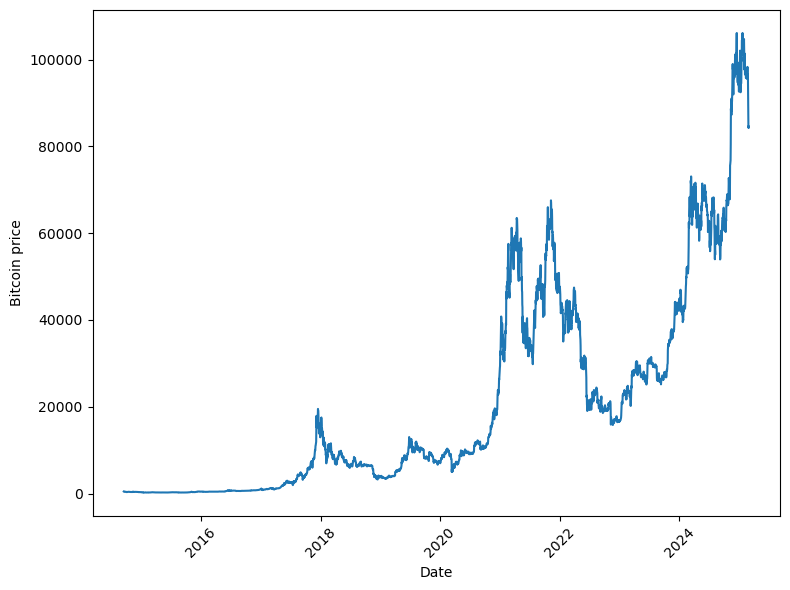

In [3]:
plt.figure(figsize=(8, 6))
plt.plot(btc_daily)
plt.xlabel('Date')
plt.ylabel('Bitcoin price')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

In [4]:
btc_daily.iloc[-1] # last price

Ticker
BTC-USD    84373.007812
Name: 2025-02-28 00:00:00, dtype: float64

In [5]:
# Worst daily return to get the "optimal" multiplier
btc_returns = btc_daily.pct_change().dropna()
lowest_return = np.min(btc_returns)
print("The lowest return is:", lowest_return)
print("On date:", btc_returns.idxmin())
print(f"Optimal Multiplier: {np.abs(1/lowest_return):.0f}")

The lowest return is: -0.37169538560117077
On date: Ticker
BTC-USD   2020-03-12
dtype: datetime64[ns]
Optimal Multiplier: 3


# Parameters

Flat period: 2019-06 to 2020-05  
Bull market: 2020-11 to 2021-10  
Bear market: 2021-11 to 2022-10  
Low-vol market: 2016-01 to 2016-12  
High-vol market: 2017-05 to 2018-04

In [6]:
initial_portfolio_value = 100000  
multipliers = [1, 2, 3, 4, 5, 6]  # Array of multipliers
floor_fractions = [0.5, 0.6, 0.7, 0.8, 0.9, 1]  # Array of floor fractions (floors for CPPI but strikes for OBPI)

In [7]:
start_date = '2017-05'
end_date = '2018-04'

btc_array = np.array(btc_daily.loc[start_date:end_date])
t_bill_array = np.array(t_bill_daily.loc[start_date:end_date])

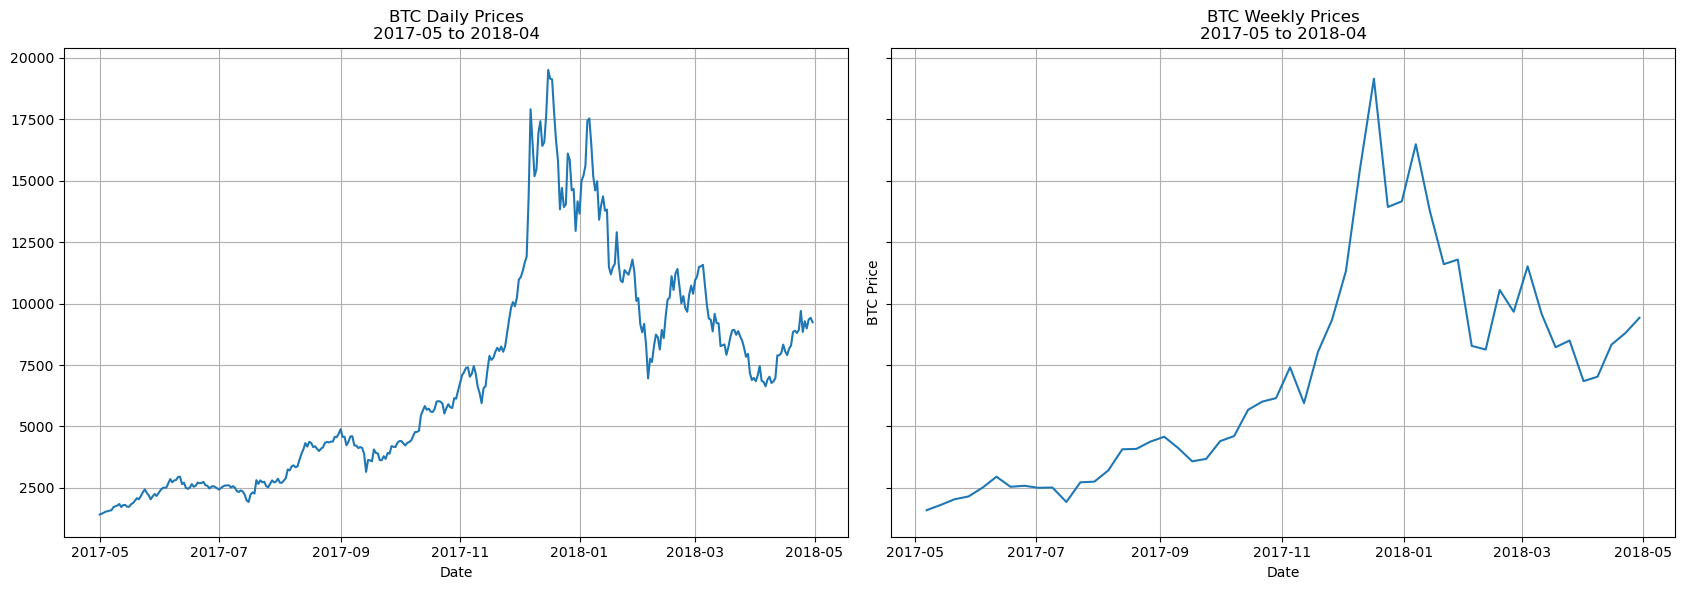

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6), sharey=True)

# Bitcoin daily prices on the left subplot (ax1)
ax1.plot(btc_daily.loc[start_date:end_date])
ax1.set_xlabel('Date')
ax1.set_title('BTC Daily Prices\n{} to {}'.format(start_date, end_date))
ax1.grid(True)

# Bitcoin weekly prices on the right subplot (ax2)
ax2.plot(btc_weekly.loc[start_date:end_date])
ax2.set_xlabel('Date')
ax2.set_ylabel('BTC Price')
ax2.set_title('BTC Weekly Prices\n{} to {}'.format(start_date, end_date))
ax2.grid(True)

plt.tight_layout()
plt.show()

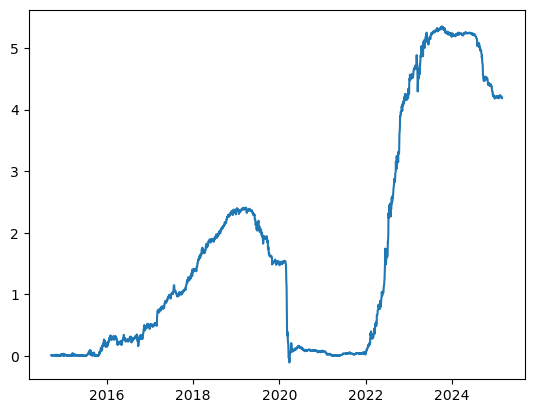

In [9]:
plt.plot(t_bill_daily) # Plot T-bill daily rates
plt.show()

# Volatility

We use the EGARCH (1,1) model to estimate the volatility of the returns.

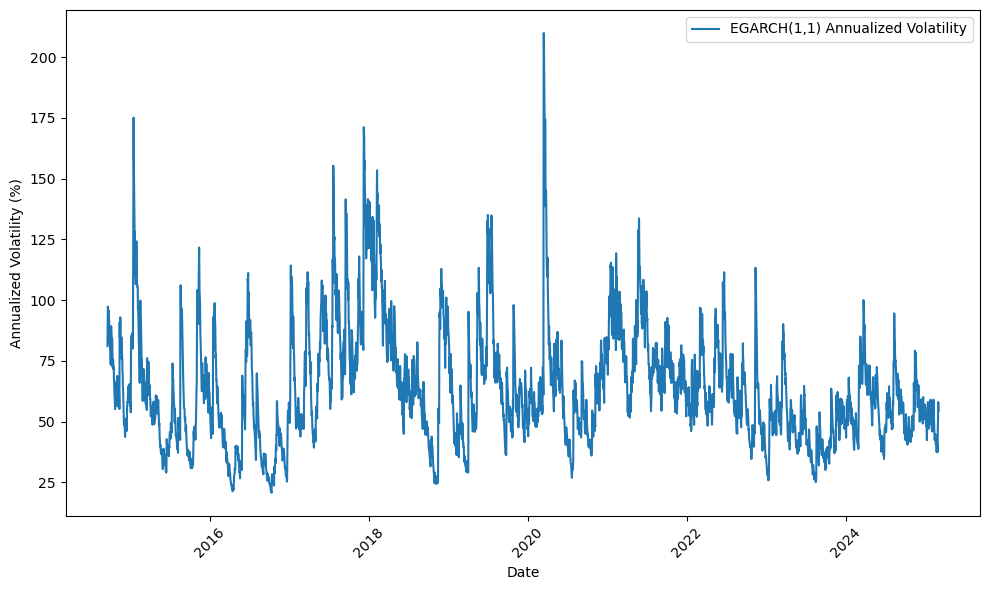

                           Constant Mean - EGARCH Model Results                           
Dep. Variable:                            BTC-USD   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 EGARCH   Log-Likelihood:               -9503.93
Distribution:      Generalized Error Distribution   AIC:                           19019.9
Method:                        Maximum Likelihood   BIC:                           19057.3
                                                    No. Observations:                 3817
Date:                            Sun, May 04 2025   Df Residuals:                     3816
Time:                                    23:14:14   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
-------------------------------

In [10]:
btc_returns = btc_daily.pct_change().dropna()
scaled_returns = btc_returns * 100 # we rescale the returns to improve convergence of the optimization algorithm

# Fit the EGARCH(1,1) model to the rescaled returns
egarch_model = arch_model(scaled_returns, vol='EGARCH', p=1, o=1, q=1, dist='GED') # using GED distribution
egarch_fit = egarch_model.fit(disp='off')

# Extract the volatility (conditional standard deviation)
egarch_volatility = egarch_fit.conditional_volatility

# Rescale it back to the original scale
egarch_volatility = egarch_volatility / 100

# Annualize it
egarch_annualized_volatility = egarch_volatility * np.sqrt(365) # here and below we use 365 because Bitcoin is traded every day

plt.figure(figsize=(10, 6))
plt.plot(btc_returns.index, egarch_annualized_volatility*100, label='EGARCH(1,1) Annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility (%)')
plt.legend()
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

print(egarch_fit.summary())

In [11]:
print('EGARCH:')
highest_volatility = egarch_annualized_volatility.rolling(window=365).mean().max()
highest_volatility_date = egarch_annualized_volatility.rolling(window=365).mean().idxmax()
print('Highest 1-Year Rolling Mean Volatility:', highest_volatility)
print('Date of Highest 1-Year Rolling Mean Volatility:', highest_volatility_date)
print('')
lowest_volatility = egarch_annualized_volatility.rolling(window=365).mean().min()
lowest_volatility_date = egarch_annualized_volatility.rolling(window=365).mean().idxmin()
print('Lowest 1-Year Rolling Mean Volatility:', lowest_volatility)
print('Date of Lowest 1-Year Rolling Mean Volatility:', lowest_volatility_date)


EGARCH:
Highest 1-Year Rolling Mean Volatility: 0.9674968379543194
Date of Highest 1-Year Rolling Mean Volatility: 2018-05-12 00:00:00

Lowest 1-Year Rolling Mean Volatility: 0.45576213913424296
Date of Lowest 1-Year Rolling Mean Volatility: 2017-01-01 00:00:00


The method above enables us to identify the one-year period with the highest and lowest volatility. Since the output date represents the end of the period, we should consider the one-year span that concludes on this date.

# Backtesting Portfolio Insurance

## CPPI

In [12]:
def cppi_strategy(risky_asset, riskless_asset, multipliers, floor_fractions, initial_portfolio_value):
    """
    Implements the CPPI strategy for multiple combinations of multiplier and floor_fraction values.

    Parameters:
        risky_asset (array-like): Prices of the risky asset.
        riskless_asset (array-like): Prices of the risk-free asset.
        multipliers (array-like): Array of multipliers.
        floor_fractions (array-like): Array of floor fractions.
        initial_portfolio_value (float): Initial value of the portfolio.

    Returns:
        dict: A dictionary containing DataFrames for each (multiplier, floor_fraction) combination.
    """
    # Convert into arrays
    risky_asset = np.asarray(risky_asset)
    riskless_asset = np.asarray(riskless_asset)

    # Ensure same length
    if len(risky_asset) != len(riskless_asset):
        raise ValueError("The lengths of risky_asset and riskless_asset must be the same.")

    dates = btc_daily.loc[start_date:end_date].index  

    results = {}

    for multiplier in multipliers:
        for floor_fraction in floor_fractions:

            # Initialization
            floor = initial_portfolio_value * floor_fraction
            cushion = max(initial_portfolio_value - floor, 0) / initial_portfolio_value

            risky_w = max(multiplier * cushion, 0)
            riskless_w = 1 - risky_w

            risky_weights = [risky_w]
            riskless_weights = [riskless_w]
            basket_values = [initial_portfolio_value]

            for i in range(1, len(risky_asset)):
                
                # Calculate returns
                risky_return = (risky_asset[i] - risky_asset[i - 1]) / risky_asset[i - 1]
                riskless_return = ((1 + riskless_asset[i] / 100) ** (1 / 365)) - 1  # divide by 100 to convert to decimal, then annualize

                # Update portfolio value
                portfolio_return = risky_w * risky_return + riskless_w * riskless_return
                basket_value = basket_values[i - 1] * (1 + portfolio_return)

                # Update weights
                cushion = max(basket_value - floor, 0) / basket_value

                risky_w = multiplier * cushion
                risky_w = max(risky_w, 0)  # ensure non-negative
                riskless_w = 1 - risky_w

                # Append the results
                risky_weights.append(risky_w)
                riskless_weights.append(riskless_w)
                basket_values.append(basket_value)

            # Convert results to a DataFrame
            cppi_df = pd.DataFrame({
                'Basket Value': basket_values,
                'Risky Weights': risky_weights,
                'Risk-Free Weights': riskless_weights
            }, index=dates)  # Set the dates

            # Store the DataFrame in the results dictionary
            results[(multiplier, floor_fraction)] = cppi_df

    return results

In [13]:
cppi_results = cppi_strategy(btc_array, t_bill_array, multipliers, floor_fractions, initial_portfolio_value)

### Analysis

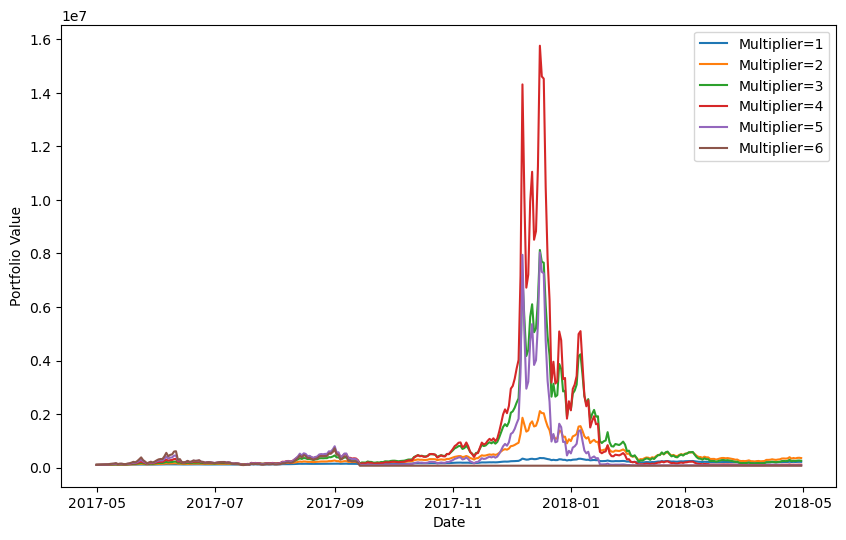

In [14]:
# Plot with one floor fixed
fixed_floor = 0.8

plt.figure(figsize=(10, 6))

for key, df in cppi_results.items():
    # Extract multiplier and floor from the key
    if isinstance(key, tuple) and len(key) == 2:
        multiplier, floor = key
    else:
        continue  # skip if key format is unexpected

    # Plot only if the floor matches the fixed floor
    if floor == fixed_floor:
        plt.plot(df.index, df['Basket Value'], label=f'Multiplier={multiplier}')

plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

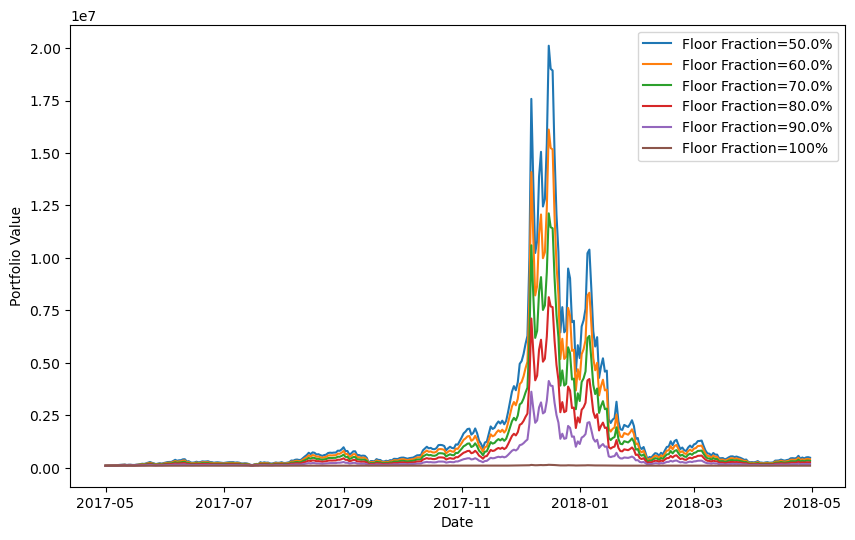

In [15]:
# Plot with multiplier fixed
fixed_multiplier = 3

plt.figure(figsize=(10, 6))

for key, df in cppi_results.items():
    # Extract multiplier and floor from the key
    if isinstance(key, tuple) and len(key) == 2:
        multiplier, floor_fraction = key
    else:
        continue  # skip if key format is unexpected

    # Plot only if the multiplier matches the fixed multiplier
    if multiplier == fixed_multiplier:
        plt.plot(df.index, df['Basket Value'], label=f'Floor Fraction={floor_fraction*100}%')

plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

In [16]:
# Find the best combination wrt final value
max_value = float('-inf')  # Initialize with negative infinity
best_params = None         # To store the best (multiplier, floor_fraction)

for (multiplier, floor_fraction), df in cppi_results.items():
    last_basket_value = df['Basket Value'].iloc[-1]
    if last_basket_value > max_value:
        max_value = last_basket_value
        best_params = (multiplier, floor_fraction)  # Update best parameters

print(f"Maximum Basket Value: {max_value}")
print(f"Best Parameters: Multiplier = {best_params[0]}, Floor Fraction = {best_params[1]}")

Maximum Basket Value: [731192.60053931]
Best Parameters: Multiplier = 2, Floor Fraction = 0.5


## OBPI

In [17]:
def obpi_strategy(risky_asset, riskless_rate, floor_fractions, initial_portfolio_value, time_to_maturity, sigma):
    """
    Implements the OBPI strategy for multiple floor fractions.

    Parameters:
        risky_asset (array-like or pd.Series): Prices of the risky asset.
        riskless_rate (array-like or pd.Series): Annualized risk-free rates.
        floor_fractions (list): List of floor fractions (strikes).
        initial_portfolio_value (float): Initial value of the portfolio.
        time_to_maturity (float): Time to maturity in years.
        sigma (float): Volatility of the risky asset (annualized).

    Returns:
        dict: Dictionary containing DataFrames for each floor_fraction (strikes).
    """
    
    def black_scholes_put(S, K, T, r, sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        put_delta = -norm.cdf(-d1)
        return put_price, put_delta

    # Convert inputs to arrays if they are not pandas Series
    if isinstance(risky_asset, pd.Series):
        risky_asset = risky_asset.values

    if isinstance(riskless_rate, pd.Series):
        riskless_rate = riskless_rate.values

    # Ensure inputs have the same length
    if len(risky_asset) != len(riskless_rate):
        raise ValueError("The lengths of risky_asset and riskless_rate must be the same.")

    results = {}
    dt = 1 / 365  

    dates = btc_daily.loc[start_date:end_date].index  

    for floor_fraction in floor_fractions:
        # Initialization
        put_price, put_delta = black_scholes_put(risky_asset[0], risky_asset[0]*floor_fraction, time_to_maturity, riskless_rate[0] / 100, sigma.iloc[0])
        
        risky_w = ((1 + put_delta) * risky_asset[0]) / (risky_asset[0] + put_price) # initial weight using the OBPI formula

        # Ensure weights are within bounds
        risky_w = max(0, min(1, risky_w))
        riskless_w = 1 - risky_w

        # Initialize lists to store results
        risky_weights = [risky_w]
        riskless_weights = [riskless_w]
        basket_values = [initial_portfolio_value]
        put_prices = [put_price]
        put_deltas = [put_delta]

        for i in range(1, len(risky_asset)):
            # Update remaining time to maturity
            remaining_ttm = time_to_maturity - i * dt

            # Calculate returns
            risky_return = (risky_asset[i] - risky_asset[i - 1]) / risky_asset[i - 1]
            riskless_return = ((1 + riskless_rate[i] / 100) ** (1 / 365)) - 1  # divide by 100 to convert to decimal, then annualize

            # Update portfolio value
            portfolio_return = risky_w * risky_return + riskless_w * riskless_return
            basket_value = basket_values[i-1] * (1 + portfolio_return)

            # Calculate put option price and delta
            put_price, put_delta = black_scholes_put(risky_asset[i], risky_asset[0]*floor_fraction, remaining_ttm, riskless_rate[i] / 100, sigma.iloc[i])
            
            # Update weights based on OBPI formula
            risky_w = ((1 + put_delta) * risky_asset[i]) / (risky_asset[i] + put_price)

            # Ensure weights are within bounds
            risky_w = max(0, min(1, risky_w))
            riskless_w = 1 - risky_w

            # Append results
            risky_weights.append(risky_w)
            riskless_weights.append(riskless_w)
            basket_values.append(basket_value)
            put_prices.append(put_price)
            put_deltas.append(put_delta)

        # Create the output DataFrame
        obpi_df = pd.DataFrame({
            'Basket Value': basket_values,
            'Risky Weights': risky_weights,
            'Risk-Free Weights': riskless_weights,
            'Put Price': put_prices,
            'Put Delta': put_deltas
        }, index=dates)

        results[floor_fraction] = obpi_df

    return results

In [18]:
time_to_maturity = len(btc_array)/365 # in years

obpi_results = obpi_strategy(btc_array, t_bill_array, floor_fractions, initial_portfolio_value, time_to_maturity, egarch_annualized_volatility[start_date:end_date])

### Analysis

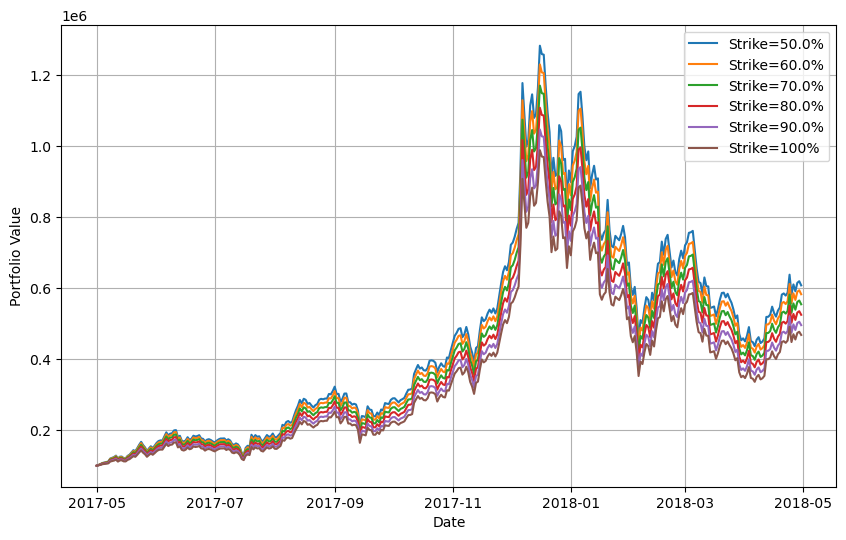

In [19]:
# Plot for the different floor levels
plotted_floors = set()  # To track already plotted floor fractions
plt.figure(figsize=(10, 6))

for floor_fraction, df in obpi_results.items():
    # Plot only if the floor fraction hasn't been plotted yet
    if floor_fraction not in plotted_floors:
        plt.plot(df.index, df['Basket Value'], label=f'Strike={floor_fraction*100}%')
        plotted_floors.add(floor_fraction)  # Mark this floor fraction as plotted

plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.legend()
plt.show()

In [20]:
# Find the best floor level wrt final value
max_value = float('-inf')  # Initialize with negative infinity
best_params = None         # To store the best floor_fraction

for (floor_fraction), df in obpi_results.items():
    last_basket_value = df['Basket Value'].iloc[-1]
    if last_basket_value > max_value:
        max_value = last_basket_value
        best_params = (floor_fraction)  # Update best parameter

print(f"Maximum Basket Value: {max_value}")
print(f"Best Parameters: Floor Fraction = {best_params}")

Maximum Basket Value: [607452.32588382]
Best Parameters: Floor Fraction = 0.5


## Buy and Hold

In [21]:
def buy_and_hold_strategy(risky_asset, riskless_rate, allocation_ratio, initial_investment):
    """
    Implements a simple B&H strategy.

    Parameters:
        risky_asset (array-like): Prices of the risky asset.
        riskless_rate (array-like): Annualized rates of the risk-free asset.
        allocation_ratio (float): The ratio of the portfolio to allocate to the risky asset.
        initial_investment (float): Initial total portfolio value.

    Returns:
        pd.DataFrame: Portfolio values for each day.
    """
    # Initial allocation
    btc_value = initial_investment * allocation_ratio
    t_bill_value = initial_investment * (1 - allocation_ratio)
    portfolio_values = []

    for i in range(1, len(risky_asset)):
        # Calculate returns
        btc_return = (risky_asset[i] - risky_asset[i - 1]) / risky_asset[i - 1]
        btc_value *= (1 + btc_return)

        t_bill_return = riskless_rate[i] / 100 / 365  
        t_bill_value *= (1 + t_bill_return)

        portfolio_values.append(btc_value + t_bill_value)

    portfolio_df = pd.DataFrame(portfolio_values, columns=["Total Portfolio Value"])

    return portfolio_df

def plot_allocation_strategy(portfolio_df, dates):
    """
    Plots the portfolio values over time.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(dates, portfolio_df['Total Portfolio Value'], label='Total Portfolio Value', color='blue')
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.grid()
    plt.show()

In [22]:
initial_investment = 100000  
allocation_ratio = 0.6  # 60% to BTC
buy_and_hold_results = buy_and_hold_strategy(btc_array, t_bill_array, allocation_ratio, initial_investment)

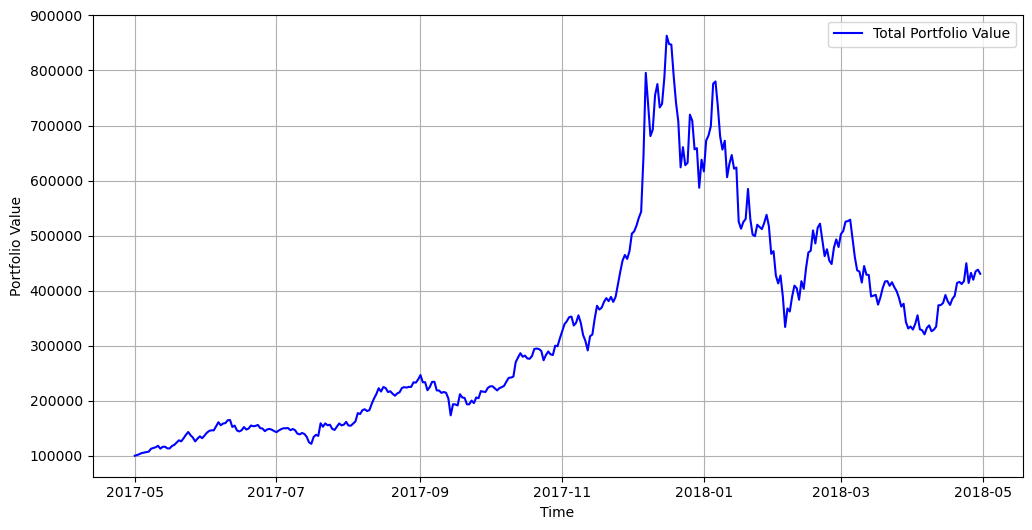

In [23]:
initial_investment_df = pd.DataFrame([initial_investment], columns=['Total Portfolio Value'], index=[btc_daily[start_date:end_date].index[0]]) 
buy_and_hold_df = pd.concat([initial_investment_df, buy_and_hold_results]).reset_index(drop=True)

plot_allocation_strategy(buy_and_hold_df, btc_daily[start_date:end_date].index)

## Comparison of the three strategies

In [24]:
# Rescale the BTC array to base 100,000
btc_array_base_100 = btc_array / btc_array[0]
btc_array_base_100 = btc_array_base_100 * 100000

In [25]:
def performance(portfolio_values):
    
    # Return
    total_return = (portfolio_values.iloc[-1] / portfolio_values.iloc[0]) - 1

    # Daily returns
    daily_returns = portfolio_values.pct_change().dropna()

    # Volatility
    volatility = np.mean(np.std(daily_returns, ddof=1)) * np.sqrt(365) if len(daily_returns) > 0 else 0

    # Sharpe ratio
    sharpe_ratio = (total_return - np.mean(t_bill_array)/100) / volatility if volatility != 0 else np.nan

    # Sortino ratio
    downside_returns = daily_returns[daily_returns < 0]
    downside_risk = np.std(downside_returns, ddof=1) * np.sqrt(365) if len(downside_returns) > 0 else 0
    sortino_ratio = (total_return - np.mean(t_bill_array)/100) / downside_risk if downside_risk != 0 else np.nan

    # VaR 5%
    var_5 = np.percentile(daily_returns, 5) if len(daily_returns) > 0 else np.nan

    # CVaR 5%
    es_5 = daily_returns[daily_returns <= var_5].mean() if len(daily_returns[daily_returns <= var_5]) > 0 else np.nan

    # Skewness
    skewness = skew(daily_returns, bias=False) if len(daily_returns) > 0 else np.nan

    # Excess Kurtosis
    excess_kurtosis = kurtosis(daily_returns, bias=False, fisher=True) if len(daily_returns) > 0 else np.nan

    # Max drawdown 
    cumulative_max = portfolio_values.cummax()
    drawdown = (portfolio_values - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min() * 100 if len(drawdown) > 0 else 0

    # Information Ratio 
    btc_returns = pd.Series(btc_array_base_100.flatten()).pct_change().dropna()
    excess_returns = np.array(daily_returns) - btc_returns
    information_ratio = (excess_returns.mean() / np.std(excess_returns, ddof=1)) * np.sqrt(365)
    
    # Tracking Error
    tracking_error = np.std(excess_returns) * np.sqrt(365) if len(excess_returns) > 0 else 0
    tracking_error = tracking_error * 100  # Convert to percentage

    return (total_return, volatility, sharpe_ratio, sortino_ratio,
            var_5, es_5, skewness, excess_kurtosis, max_drawdown, information_ratio, tracking_error)

def turnover(w):
    """
    Compute the turnover for one or multiple simulations.
    
    - If input is 1D (shape (n_steps,)), treats it as one simulation and returns the turnover.
    - If input is 2D (shape (n_steps, n_simulations)), computes the turnover for each simulation 
      and returns the average turnover across simulations.
    
    Parameters:
    - w: Array-like, weights over time.
    
    Returns:
    - float: The turnover or average turnover.
    """
    # Convert input array
    w = np.asarray(w)
    
    # If 1D, reshape to 2D with one column
    if w.ndim == 1:
        w = w.reshape(-1, 1)
    # If not 1D or 2D, raise an error
    elif w.ndim != 2:
        raise ValueError("Input must be 1D or 2D array")
    
    # Compute differences between consecutive weights
    diffs = np.diff(w, axis=0)
    # Compute absolute values of differences
    abs_diffs = np.abs(diffs)
    # Sum absolute differences for each simulation
    turnovers = np.sum(abs_diffs, axis=0)
    # Compute the average turnover across simulations
    average_turnover = np.mean(turnovers)
    
    return average_turnover*100
    
# CPPI 
cppi_strategy_results = cppi_results[(3, 0.8)]
cppi_portfolio_values = pd.Series(cppi_strategy_results['Basket Value']).apply(
    lambda x: x[0] if isinstance(x, np.ndarray) else x)
cppi_metrics = performance(cppi_portfolio_values)
cppi_turnover = turnover(cppi_strategy_results['Risky Weights'])

# OBPI 
obpi_strategy_results = obpi_results[1]
obpi_portfolio_values = pd.Series(obpi_strategy_results['Basket Value']).apply(
    lambda x: x[0] if isinstance(x, np.ndarray) else x)
obpi_metrics = performance(obpi_portfolio_values)
obpi_turnover = turnover(obpi_strategy_results['Risky Weights'])

# Buy-and-Hold 
bnh_portfolio_values = buy_and_hold_df['Total Portfolio Value'].apply(
    lambda x: x[0] if isinstance(x, np.ndarray) else x)
bnh_metrics = performance(bnh_portfolio_values)
bnh_turnover = 0

# Print results
print(f"CPPI Annualized Return: {cppi_metrics[0]:.2%}")
print(f"CPPI Annualized Volatility: {cppi_metrics[1]:.2%}")
print(f"CPPI Sharpe Ratio: {cppi_metrics[2]:.2f}")
print(f"CPPI Sortino Ratio: {cppi_metrics[3]:.2f}")
print(f"CPPI VaR 5%: {cppi_metrics[4]:.2%}")
print(f"CPPI Expected Shortfall 5%: {cppi_metrics[5]:.2%}")
print(f"CPPI Skewness: {cppi_metrics[6]:.2f}")
print(f"CPPI Excess Kurtosis: {cppi_metrics[7]:.2f}")
print(f"CPPI Turnover: {cppi_turnover.item():.2f}%")
print(f"CPPI Max Drawdown: {cppi_metrics[8]:.2f}%")
print(f"CPPI Information Ratio: {cppi_metrics[9]:.2f}")
print(f"CPPI Tracking Error: {cppi_metrics[10]:.2f}%")
print("")

print(f"OBPI Annualized Return: {obpi_metrics[0]:.2%}")
print(f"OBPI Annualized Volatility: {obpi_metrics[1]:.2%}")
print(f"OBPI Sharpe Ratio: {obpi_metrics[2]:.2f}")
print(f"OBPI Sortino Ratio: {obpi_metrics[3]:.2f}")
print(f"OBPI VaR 5%: {obpi_metrics[4]:.2%}")
print(f"OBPI Expected Shortfall 5%: {obpi_metrics[5]:.2%}")
print(f"OBPI Skewness: {obpi_metrics[6]:.2f}")
print(f"OBPI Excess Kurtosis: {obpi_metrics[7]:.2f}")
print(f"OBPI Turnover: {obpi_turnover.item():.2f}%")
print(f"OBPI Max Drawdown: {obpi_metrics[8]:.2f}%")
print(f"OBPI Information Ratio: {obpi_metrics[9]:.2f}")
print(f"OBPI Tracking Error: {obpi_metrics[10]:.2f}%")
print("")

print(f"B&H Annualized Return: {bnh_metrics[0]:.2%}")
print(f"B&H Annualized Volatility: {bnh_metrics[1]:.2%}")
print(f"B&H Sharpe Ratio: {bnh_metrics[2]:.2f}")
print(f"B&H Sortino Ratio: {bnh_metrics[3]:.2f}")
print(f"B&H VaR 5%: {bnh_metrics[4]:.2%}")
print(f"B&H Expected Shortfall 5%: {bnh_metrics[5]:.2%}")
print(f"B&H Skewness: {bnh_metrics[6]:.2f}")
print(f"B&H Excess Kurtosis: {bnh_metrics[7]:.2f}")
print(f"B&H Turnover: {bnh_turnover:.2f}%")
print(f"B&H Max Drawdown: {bnh_metrics[8]:.2f}%")
print(f"B&H Information Ratio: {bnh_metrics[9]:.2f}")
print(f"B&H Tracking Error: {bnh_metrics[10]:.2f}%")

CPPI Annualized Return: 153.30%
CPPI Annualized Volatility: 245.90%
CPPI Sharpe Ratio: 0.62
CPPI Sortino Ratio: 0.89
CPPI VaR 5%: -19.18%
CPPI Expected Shortfall 5%: -27.76%
CPPI Skewness: 0.41
CPPI Excess Kurtosis: 4.53
CPPI Turnover: 2198.58%
CPPI Max Drawdown: -98.11%
CPPI Information Ratio: 1.04
CPPI Tracking Error: 146.36%

OBPI Annualized Return: 367.93%
OBPI Annualized Volatility: 100.63%
OBPI Sharpe Ratio: 3.64
OBPI Sortino Ratio: 5.63
OBPI VaR 5%: -7.87%
OBPI Expected Shortfall 5%: -10.77%
OBPI Skewness: 0.23
OBPI Excess Kurtosis: 2.32
OBPI Turnover: 269.02%
OBPI Max Drawdown: -65.99%
OBPI Information Ratio: -2.97
OBPI Tracking Error: 13.14%

B&H Annualized Return: 330.50%
B&H Annualized Volatility: 91.43%
B&H Sharpe Ratio: 3.60
B&H Sortino Ratio: 5.58
B&H VaR 5%: -7.14%
B&H Expected Shortfall 5%: -9.78%
B&H Skewness: 0.29
B&H Excess Kurtosis: 2.50
B&H Turnover: 0.00%
B&H Max Drawdown: -62.86%
B&H Information Ratio: -3.05
B&H Tracking Error: 18.42%


In [26]:
# Metrics for Bitcoin price
# Compute Returns
btc_prices = btc_array.flatten()
daily_returns = btc_prices[1:] / btc_prices[:-1] - 1
total_return = (btc_prices[-1] / btc_prices[0]) - 1

# Volatility
annualized_volatility = np.mean(np.std(daily_returns, ddof=1)) * np.sqrt(365)

# Sharpe Ratio 
sharpe_ratio = (total_return - np.mean(t_bill_array)/100) / annualized_volatility

# Sortino Ratio
downside_returns = daily_returns[daily_returns < 0]
downside_volatility = np.std(downside_returns, ddof=1) * np.sqrt(365)
sortino_ratio = (total_return - np.mean(t_bill_array)/100) / downside_volatility

# VaR 5%
var_5 = np.percentile(daily_returns, 5)

# CVaR 5%
expected_shortfall_5 = np.mean(daily_returns[daily_returns <= var_5])

# Skewness 
returns_skewness = skew(daily_returns, bias=False)

# Excess Kurtosis 
returns_kurtosis = kurtosis(daily_returns, bias=False, fisher=True)  

# Max Drawdown 
cumulative_returns = (1 + daily_returns).cumprod()
peak = np.maximum.accumulate(cumulative_returns)
drawdown = (cumulative_returns - peak) / peak
max_drawdown = drawdown.min()

# Output results
{
    "Annualized Return": f"{total_return * 100:.2f}%",
    "Annualized Volatility": f"{annualized_volatility * 100:.2f}%",
    "Sharpe Ratio": f"{sharpe_ratio:.2f}",
    "Sortino Ratio": f"{sortino_ratio:.2f}",
    "VaR (5%)": f"{var_5 * 100:.2f}%",
    "Expected Shortfall (5%)": f"{expected_shortfall_5 * 100:.2f}%",
    "Skewness": f"{returns_skewness:.2f}",
    "Excess Kurtosis": f"{returns_kurtosis:.2f}",
    "Max Drawdown": f"{max_drawdown * 100:.2f}%"
}

{'Annualized Return': '550.01%',
 'Annualized Volatility': '106.63%',
 'Sharpe Ratio': '5.15',
 'Sortino Ratio': '8.29',
 'VaR (5%)': '-7.91%',
 'Expected Shortfall (5%)': '-10.98%',
 'Skewness': '0.32',
 'Excess Kurtosis': '2.20',
 'Max Drawdown': '-65.96%'}

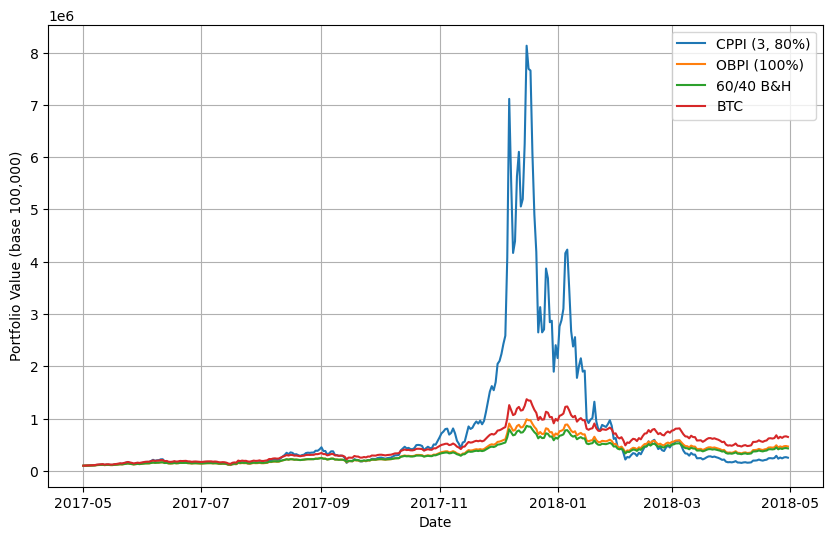

In [27]:
plt.figure(figsize=(10, 6))

# CPPI
plt.plot(cppi_results[(3, 0.8)]['Basket Value'], label='CPPI (3, 80%)')

# OBPI 
plt.plot(obpi_results[1]['Basket Value'], label='OBPI (100%)')

# B&H 
plt.plot(cppi_results[(6, 0.9)]['Basket Value'].index, buy_and_hold_df['Total Portfolio Value'], label='60/40 B&H')

# BTC prices as base 100,000
plt.plot(cppi_results[(6, 0.9)]['Basket Value'].index, btc_array_base_100, label='BTC')

plt.xlabel('Date')
plt.ylabel('Portfolio Value (base 100,000)')
plt.legend()
plt.grid(True)
plt.show()

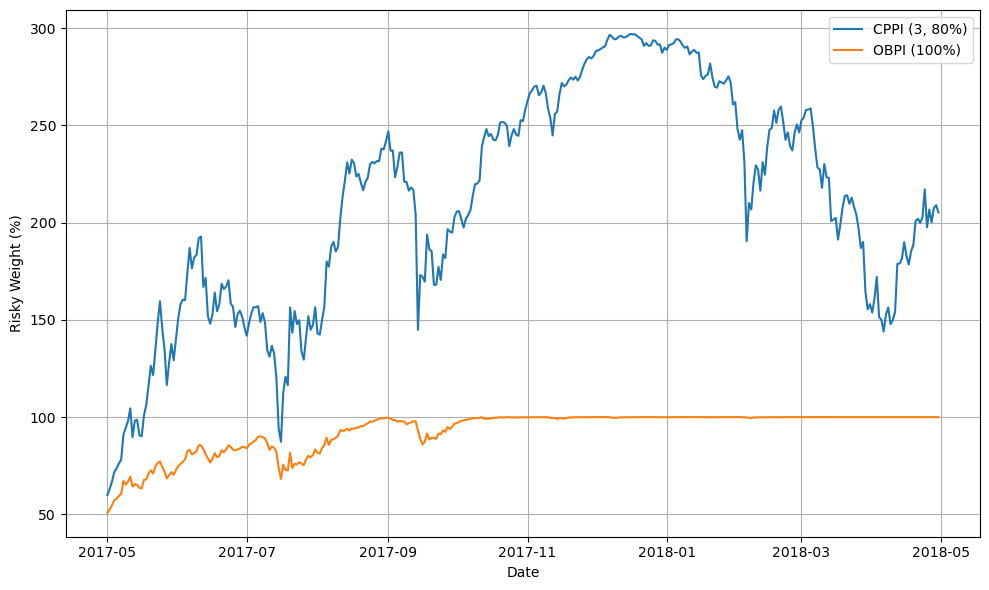

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(cppi_results[(3, 0.8)]['Risky Weights']*100, label='CPPI (3, 80%)')
plt.plot(obpi_results[(1)]['Risky Weights']*100, label='OBPI (100%)')
plt.xlabel('Date')
plt.ylabel('Risky Weight (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## CPPI Move-based rebalancing

In [29]:
def cppi_strategy_move_based_rebalancing(risky_asset, riskless_asset, multipliers, floor_fractions, initial_portfolio_value, move_thresholds):
    """
    Implements the CPPI strategy with move-based rebalancing for multiple combinations
    of multiplier and floor_fraction values.

    Parameters:
        risky_asset (array-like): Prices of the risky asset.
        riskless_asset (array-like): Prices of the risk-free asset.
        multipliers (array-like): Array of multipliers.
        floor_fractions (array-like): Array of floor fractions.
        initial_portfolio_value (float): Initial value of the portfolio.
        move_thresholds (array-like): Array of thresholds for rebalancing.

    Returns:
        dict: A dictionary containing DataFrames for each (multiplier, floor_fraction, move_threshold) combination.
    """
    # Convert inputs to numpy arrays
    risky_asset = np.asarray(risky_asset)
    riskless_asset = np.asarray(riskless_asset)

    # Validate input lengths
    if len(risky_asset) != len(riskless_asset):
        raise ValueError("The lengths of risky_asset and riskless_asset must be the same.")

    dates = btc_daily.loc[start_date:end_date].index  

    results = {}

    for multiplier in multipliers:
        for floor_fraction in floor_fractions:
            for move_threshold in move_thresholds:
                # Initialization
                floor = initial_portfolio_value * floor_fraction
                cushion = max(initial_portfolio_value - floor, 0) / initial_portfolio_value

                risky_w = max(multiplier * cushion, 0)
                riskless_w = 1 - risky_w

                risky_weights = [risky_w]
                riskless_weights = [riskless_w]
                basket_values = [initial_portfolio_value]

                for i in range(1, len(risky_asset)):
                    # Calculate returns
                    risky_return = (risky_asset[i] - risky_asset[i - 1]) / risky_asset[i - 1]
                    riskless_return = ((1 + riskless_asset[i] / 100) ** (1 / 365)) - 1 # divide by 100 to convert to decimal, then annualize

                    # Update portfolio value
                    portfolio_return = risky_w * risky_return + riskless_w * riskless_return
                    basket_value = basket_values[i - 1] * (1 + portfolio_return)

                    # Calculate new cushion and target weights
                    cushion = max(basket_value - floor, 0) / basket_value
                    new_target_risky_w = max(multiplier * cushion, 0)
                    new_target_riskless_w = 1 - new_target_risky_w

                    # Check if rebalancing is needed based on move threshold
                    if abs(risky_w - new_target_risky_w) >= move_threshold:
                        # Update weights only when threshold is exceeded or reached
                        risky_w = new_target_risky_w
                        riskless_w = new_target_riskless_w

                    # Append results
                    risky_weights.append(risky_w)
                    riskless_weights.append(riskless_w)
                    basket_values.append(basket_value)

                # Create DataFrame for results
                cppi_df = pd.DataFrame({
                    'Basket Value': basket_values,
                    'Risky Weights': risky_weights,
                    'Risk-Free Weights': riskless_weights
                }, index=dates)

                # Store in results dictionary 
                results[(multiplier, floor_fraction, move_threshold)] = cppi_df

    return results

In [30]:
move_thresholds = [0, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5]

cppi_results_move_based_rebalancing = cppi_strategy_move_based_rebalancing(btc_array, t_bill_array, [3], [0.8], initial_portfolio_value, move_thresholds)

In [31]:
# Iterate over results for (multiplier=3, floor_fraction=0.8) across thresholds
for key, result in cppi_results_move_based_rebalancing.items():
    multiplier, floor_fraction, threshold = key

    turnover_value = turnover(result['Risky Weights'])
    print(f"Threshold: {threshold}, Multiplier: {multiplier}, Floor: {floor_fraction} → Turnover: {turnover_value}")

Threshold: 0, Multiplier: 3, Floor: 0.8 → Turnover: [2198.5806606]
Threshold: 0.01, Multiplier: 3, Floor: 0.8 → Turnover: [2172.03605624]
Threshold: 0.025, Multiplier: 3, Floor: 0.8 → Turnover: [2103.77188282]
Threshold: 0.05, Multiplier: 3, Floor: 0.8 → Turnover: [1864.03247628]
Threshold: 0.1, Multiplier: 3, Floor: 0.8 → Turnover: [1504.20903636]
Threshold: 0.25, Multiplier: 3, Floor: 0.8 → Turnover: [1063.55468584]
Threshold: 0.5, Multiplier: 3, Floor: 0.8 → Turnover: [729.53779604]


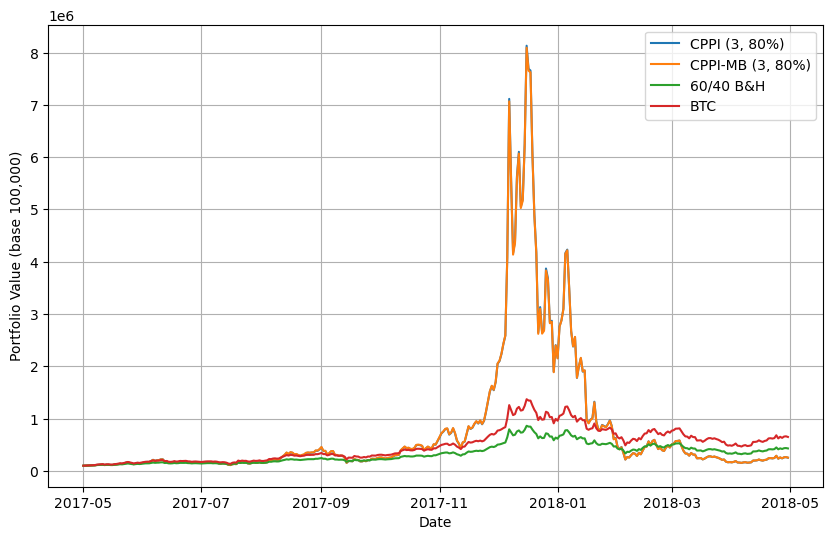

In [32]:
threshold = 0.05

plt.figure(figsize=(10, 6))

# CPPI
plt.plot(cppi_results[(3, 0.8)]['Basket Value'], label='CPPI (3, 80%)')

# CPPI Move based rebalancing
plt.plot(cppi_results_move_based_rebalancing[(3, 0.8, threshold)]['Basket Value'], label='CPPI-MB (3, 80%)')

# B&H 
plt.plot(cppi_results[(6, 0.9)]['Basket Value'].index, buy_and_hold_df['Total Portfolio Value'], label='60/40 B&H')

# BTC prices as base 100,000
plt.plot(cppi_results[(6, 0.9)]['Basket Value'].index, btc_array_base_100, label='BTC')

plt.xlabel('Date')
plt.ylabel('Portfolio Value (base 100,000)')
plt.legend()
plt.grid(True)
plt.show()

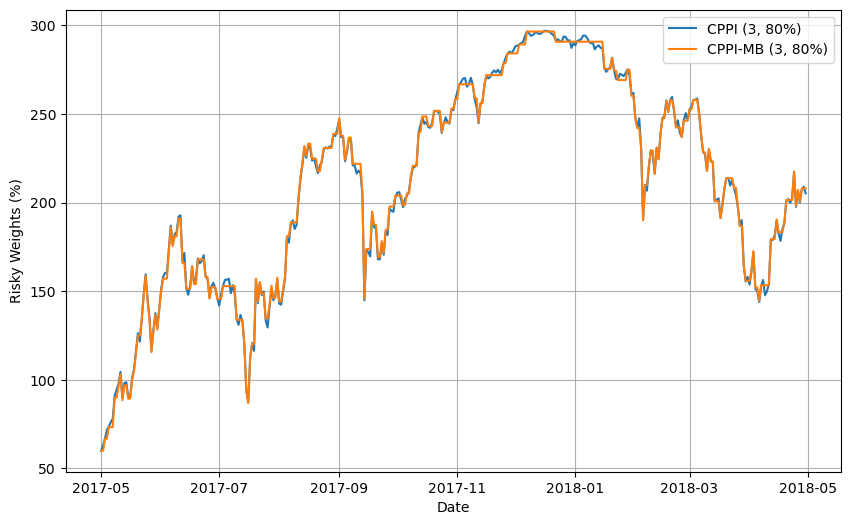

In [33]:
threshold = 0.05

plt.figure(figsize=(10, 6))

# CPPI
plt.plot(cppi_results[(3, 0.8)]['Risky Weights']*100, label='CPPI (3, 80%)')

# CPPI Move based rebalancing
plt.plot(cppi_results_move_based_rebalancing[(3, 0.8, threshold)]['Risky Weights']*100, label='CPPI-MB (3, 80%)')

plt.xlabel('Date')
plt.ylabel('Risky Weights (%)')
plt.legend()
plt.grid(True)
plt.show()

## OBPI Move-Based Rebalancing

In [34]:
def obpi_strategy_move_based_rebalancing(risky_asset, riskless_rate, floor_fractions, initial_portfolio_value, time_to_maturity, sigma, delta_moves):
    """
    Implements the OBPI strategy with move-based rebalancing for multiple floor fractions.

    Parameters:
        risky_asset (array-like or pd.Series): Prices of the risky asset.
        riskless_rate (array-like or pd.Series): Annualized risk-free rates.
        floor_fractions (list): List of floor fractions (strikes).
        initial_portfolio_value (float): Initial value of the portfolio.
        time_to_maturity (float): Time to maturity in years.
        sigma (float or pd.Series): Volatility of the risky asset (annualized).
        delta_moves (array-like): Array of thresholds for rebalancing.

    Returns:
        dict: Dictionary containing DataFrames for each (floor_fraction, delta_move) combination.
    """
    
    def black_scholes_put(S, K, T, r, sigma):
        # Handle case where T <= 0
        if T <= 0:
            put_price = max(K - S, 0)
            put_delta = -1.0 if S <= K else 0.0
            return put_price, put_delta
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        put_delta = -norm.cdf(-d1)
        return put_price, put_delta

    # Convert inputs to NumPy arrays if they are pandas Series
    if isinstance(risky_asset, pd.Series):
        risky_asset = risky_asset.values
    if isinstance(riskless_rate, pd.Series):
        riskless_rate = riskless_rate.values
    if isinstance(sigma, pd.Series):
        sigma = sigma.values

    # Ensure inputs have the same length
    if len(risky_asset) != len(riskless_rate):
        raise ValueError("The lengths of risky_asset and riskless_rate must be the same.")
    if len(risky_asset) != len(sigma):
        raise ValueError("The lengths of risky_asset and sigma must be the same.")

    results = {}
    dt = 1 / 365  

    dates = btc_daily.loc[start_date:end_date].index 

    for floor_fraction in floor_fractions:
        for delta_move in delta_moves:

            # Initialization
            put_price, put_delta = black_scholes_put(risky_asset[0], risky_asset[0] * floor_fraction, time_to_maturity, riskless_rate[0] / 100, sigma[0])

            # Calculate initial weights based on OBPI formula
            risky_w = ((1 + put_delta) * risky_asset[0]) / (risky_asset[0] + put_price)
            risky_w = max(0, min(1, risky_w))
            riskless_w = 1 - risky_w

            # Initialize lists to store results
            risky_weights = [risky_w]
            riskless_weights = [riskless_w]
            basket_values = [initial_portfolio_value]
            put_prices = [put_price]
            put_deltas = [put_delta]

            for i in range(1, len(risky_asset)):
                # Update remaining time to maturity
                remaining_ttm = time_to_maturity - i * dt

                # Calculate returns
                risky_return = (risky_asset[i] - risky_asset[i - 1]) / risky_asset[i - 1]
                riskless_return = ((1 + riskless_rate[i] / 100) ** (1 / 365)) - 1

                # Update portfolio value
                portfolio_return = risky_w * risky_return + riskless_w * riskless_return
                basket_value = basket_values[i-1] * (1 + portfolio_return)

                # Calculate new put option price and delta
                put_price, put_delta = black_scholes_put(risky_asset[i], risky_asset[0] * floor_fraction, remaining_ttm, riskless_rate[i] / 100, sigma[i])
                
                # Calculate new target weights based on OBPI formula
                new_target_risky_w = ((1 + put_delta) * risky_asset[i]) / (risky_asset[i] + put_price)
                new_target_risky_w = max(0, min(1, new_target_risky_w))
                new_target_riskless_w = 1 - new_target_risky_w

                # Check if rebalancing is needed based on delta_move threshold
                if abs(risky_w - new_target_risky_w) >= delta_move:
                    # Update weights only when threshold is exceeded or reached
                    risky_w = new_target_risky_w
                    riskless_w = new_target_riskless_w

                # Append results
                risky_weights.append(risky_w)
                riskless_weights.append(riskless_w)
                basket_values.append(basket_value)
                put_prices.append(put_price)
                put_deltas.append(put_delta)

            # Create the output DataFrame
            obpi_df = pd.DataFrame({
                'Basket Value': basket_values,
                'Risky Weights': risky_weights,
                'Risk-Free Weights': riskless_weights,
                'Put Price': put_prices,
                'Put Delta': put_deltas
            }, index=dates)

            # Store in results dictionary 
            results[(floor_fraction, delta_move)] = obpi_df

    return results

In [35]:
delta_moves = [0, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5]

obpi_results_move_based_rebalancing = obpi_strategy_move_based_rebalancing(btc_array, t_bill_array, [1], initial_portfolio_value, 1, egarch_annualized_volatility[start_date:end_date], delta_moves)

In [36]:
# Iterate over results for (floor_fraction=1) across thresholds
for key, result in obpi_results_move_based_rebalancing.items():
    floor_fraction, threshold = key

    turnover_value = turnover(result['Risky Weights'])
    print(f"Threshold: {threshold}, Floor: {floor_fraction} → Turnover: {turnover_value}")

Threshold: 0, Floor: 1 → Turnover: [269.02389031]
Threshold: 0.01, Floor: 1 → Turnover: [233.42271431]
Threshold: 0.025, Floor: 1 → Turnover: [194.24932452]
Threshold: 0.05, Floor: 1 → Turnover: [140.55306611]
Threshold: 0.1, Floor: 1 → Turnover: [70.39241453]
Threshold: 0.25, Floor: 1 → Turnover: [25.5344126]
Threshold: 0.5, Floor: 1 → Turnover: [0.]


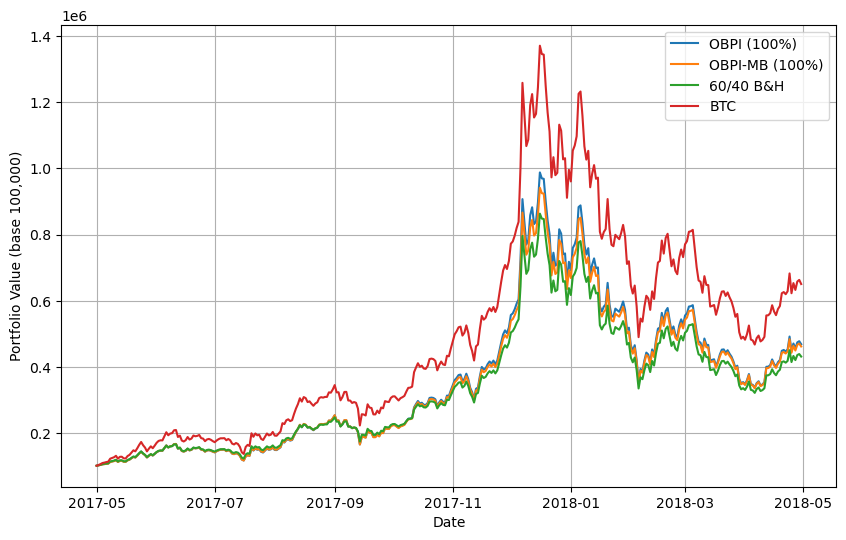

In [37]:
threshold = 0.05

plt.figure(figsize=(10, 6))

# OBPI
plt.plot(obpi_results[(1)]['Basket Value'], label='OBPI (100%)')

# OBPI Move based rebalancing
plt.plot(obpi_results_move_based_rebalancing[(1, threshold)]['Basket Value'], label='OBPI-MB (100%)')

# B&H
plt.plot(cppi_results[(6, 0.9)]['Basket Value'].index, buy_and_hold_df['Total Portfolio Value'], label='60/40 B&H')

# BTC prices as base 100,000
plt.plot(cppi_results[(6, 0.9)]['Basket Value'].index, btc_array_base_100, label='BTC')

plt.xlabel('Date')
plt.ylabel('Portfolio Value (base 100,000)')
plt.legend()
plt.grid(True)
plt.show()

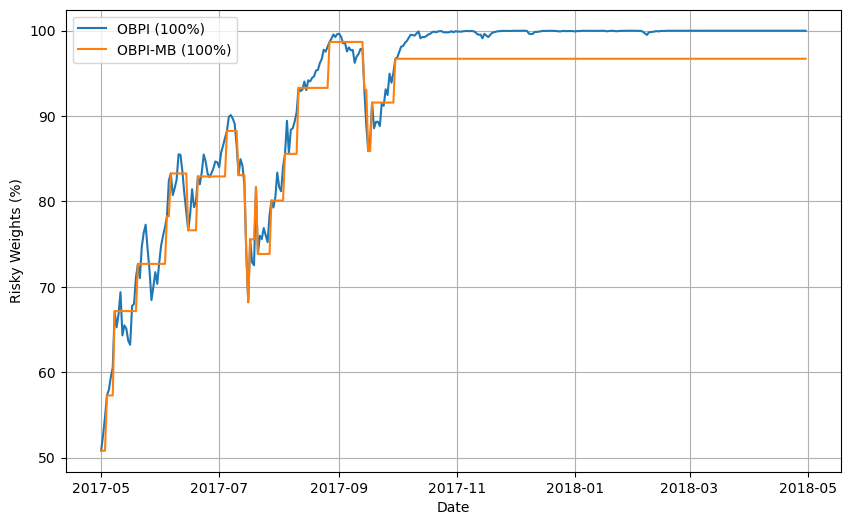

In [38]:
threshold = 0.05

plt.figure(figsize=(10, 6))

# OBPI
plt.plot(obpi_results[1]['Risky Weights']*100, label='OBPI (100%)')

# OBPI Move based rebalancing
plt.plot(obpi_results_move_based_rebalancing[(1, threshold)]['Risky Weights']*100, label='OBPI-MB (100%)')

plt.xlabel('Date')
plt.ylabel('Risky Weights (%)')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
for threshold in [0.01, 0.025, 0.05, 0.1, 0.25]:

    # CPPI 
    cppi_strategy_results = cppi_results_move_based_rebalancing[(3, 0.8, threshold)]
    cppi_portfolio_values = pd.Series(cppi_strategy_results['Basket Value']).apply(
        lambda x: x[0] if isinstance(x, np.ndarray) else x)
    cppi_metrics = performance(cppi_portfolio_values)
    cppi_turnover = turnover(cppi_strategy_results['Risky Weights'])

    # OBPI 
    obpi_strategy_results = obpi_results_move_based_rebalancing[1, threshold]
    obpi_portfolio_values = pd.Series(obpi_strategy_results['Basket Value']).apply(
        lambda x: x[0] if isinstance(x, np.ndarray) else x)
    obpi_metrics = performance(obpi_portfolio_values)
    obpi_turnover = turnover(obpi_strategy_results['Risky Weights'])

    # Print results
    print(f"Threshold: {threshold}")
    print(f"CPPI Annualized Return: {cppi_metrics[0]:.2%}")
    print(f"CPPI Annualized Volatility: {cppi_metrics[1]:.2%}")
    print(f"CPPI Sharpe Ratio: {cppi_metrics[2]:.2f}")
    print(f"CPPI Sortino Ratio: {cppi_metrics[3]:.2f}")
    print(f"CPPI VaR 5%: {cppi_metrics[4]:.2%}")
    print(f"CPPI Expected Shortfall 5%: {cppi_metrics[5]:.2%}")
    print(f"CPPI Skewness: {cppi_metrics[6]:.2f}")
    print(f"CPPI Excess Kurtosis: {cppi_metrics[7]:.2f}")
    print(f"CPPI Turnover: {cppi_turnover.item():.2f}%")
    print(f"CPPI Max Drawdown: {cppi_metrics[8]:.2f}%")
    print(f"CPPI Information Ratio: {cppi_metrics[9]:.2f}")
    print(f"CPPI Tracking Error: {cppi_metrics[10]:.2f}%")
    print("")

    print(f"OBPI Annualized Return: {obpi_metrics[0]:.2%}")
    print(f"OBPI Annualized Volatility: {obpi_metrics[1]:.2%}")
    print(f"OBPI Sharpe Ratio: {obpi_metrics[2]:.2f}")
    print(f"OBPI Sortino Ratio: {obpi_metrics[3]:.2f}")
    print(f"OBPI VaR 5%: {obpi_metrics[4]:.2%}")
    print(f"OBPI Expected Shortfall 5%: {obpi_metrics[5]:.2%}")
    print(f"OBPI Skewness: {obpi_metrics[6]:.2f}")
    print(f"OBPI Excess Kurtosis: {obpi_metrics[7]:.2f}")
    print(f"OBPI Turnover: {obpi_turnover.item():.2f}%")
    print(f"OBPI Max Drawdown: {obpi_metrics[8]:.2f}%")
    print(f"OBPI Information Ratio: {obpi_metrics[9]:.2f}")
    print(f"OBPI Tracking Error: {obpi_metrics[10]:.2f}%")
    print("")

Threshold: 0.01
CPPI Annualized Return: 153.29%
CPPI Annualized Volatility: 245.93%
CPPI Sharpe Ratio: 0.62
CPPI Sortino Ratio: 0.89
CPPI VaR 5%: -19.18%
CPPI Expected Shortfall 5%: -27.77%
CPPI Skewness: 0.41
CPPI Excess Kurtosis: 4.52
CPPI Turnover: 2172.04%
CPPI Max Drawdown: -98.11%
CPPI Information Ratio: 1.04
CPPI Tracking Error: 146.37%

OBPI Annualized Return: 370.51%
OBPI Annualized Volatility: 100.09%
OBPI Sharpe Ratio: 3.69
OBPI Sortino Ratio: 5.71
OBPI VaR 5%: -7.85%
OBPI Expected Shortfall 5%: -10.70%
OBPI Skewness: 0.24
OBPI Excess Kurtosis: 2.31
OBPI Turnover: 233.42%
OBPI Max Drawdown: -65.61%
OBPI Information Ratio: -2.97
OBPI Tracking Error: 13.12%

Threshold: 0.025
CPPI Annualized Return: 149.26%
CPPI Annualized Volatility: 245.21%
CPPI Sharpe Ratio: 0.60
CPPI Sortino Ratio: 0.87
CPPI VaR 5%: -19.19%
CPPI Expected Shortfall 5%: -27.73%
CPPI Skewness: 0.41
CPPI Excess Kurtosis: 4.54
CPPI Turnover: 2103.77%
CPPI Max Drawdown: -98.10%
CPPI Information Ratio: 1.02
CPPI T